In [101]:
from scipy import signal
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import os

In [102]:
# Primary-Consistent Soft-Decision method (Wu and Zhang, 2004)
# grbg format

Gx_conv = np.array([[0, 0, 0, 0, 0], 
                   [0, 0, 0, 0, 0], 
                   [-1, 2, 2, 2, -1], 
                   [0, 0, 0, 0, 0], 
                   [0, 0, 0, 0, 0]]) / 4
Gy_conv = Gx_conv.T
RB_at_Gx_conv = np.array([[0, 0, 0], [1, 0, 1], [0, 0, 0]]) / 2
RB_at_Gy_conv = RB_at_Gx_conv.T
RB_at_BR_conv = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]]) / 4


def Reflective_Padding1(img):
    """
    Reflective padding for 3*3 kernel convolution.
    """
    length = img.shape[0]
    width = img.shape[1]
    padded_length = length + 2
    padded_width = width + 2
    
    padded_img = np.zeros((padded_length, padded_width))
    padded_img[1:padded_length-1, 1:padded_width-1] = img
    padded_img[0, 1:padded_width-1] = padded_img[2, 1:padded_width-1]
    padded_img[padded_length-1, 1:padded_width-1] = padded_img[padded_length-3, 1:padded_width-1]
    padded_img[:, 0] = padded_img[:, 2]
    padded_img[:, padded_width-1] = padded_img[:, padded_width-3]
    
    return padded_img


def Reflective_Padding2(img):
    """
    Reflective padding for 5*5 kernel convolution.
    """
    length = img.shape[0]
    width = img.shape[1]
    padded_length = length + 4
    padded_width = width + 4
    
    padded_img = np.zeros((padded_length, padded_width))
    padded_img[2:padded_length-2, 2:padded_width-2] = img
    padded_img[0, 2:padded_width-2] = padded_img[2, 2:padded_width-2]
    padded_img[1, 2:padded_width-2] = padded_img[3, 2:padded_width-2]
    padded_img[padded_length-1, 2:padded_width-2] = padded_img[padded_length-3, 2:padded_width-2]
    padded_img[padded_length-2, 2:padded_width-2] = padded_img[padded_length-4, 2:padded_width-2]
    padded_img[:, 0] = padded_img[:, 2]
    padded_img[:, 1] = padded_img[:, 3]
    padded_img[:, padded_width-1] = padded_img[:, padded_width-3]
    padded_img[:, padded_width-2] = padded_img[:, padded_width-4]
    
    return padded_img


def Local_Gradient(i, j, R_G, B_G, axis=0):
    """
    Calculate the sum of horizontal / vertical gradients within the 3*3 window.
    """
    delta = 0
    if axis == 0:
        for k in range(3):
            delta += sum(
                [abs(R_G[i+k][j+1] - R_G[i+k][j]), abs(B_G[i+k][j+1] - B_G[i+k][j]),
                abs(R_G[i+k][j+2] - R_G[i+k][j+1]), abs(B_G[i+k][j+2] - B_G[i+k][j+1]),
                abs(R_G[i+k][j+2] - R_G[i+k][j]), abs(B_G[i+k][j+2] - B_G[i+k][j])]
            )
    else:
        for k in range(3):
            delta += sum(
                [abs(R_G[i+1][j+k] - R_G[i][j+k]), abs(B_G[i+1][j+k] - B_G[i][j+k]),
                abs(R_G[i+2][j+k] - R_G[i+1][j+k]), abs(B_G[i+2][j+k] - B_G[i+1][j+k]),
                abs(R_G[i+2][j+k] - R_G[i][j+k]), abs(B_G[i+2][j+k] - B_G[i][j+k])]
            )
            
    return delta


def PCSD_Demosaicing(img):
    """
    The demosaicing algorithm of Primary-Consistent Soft-Decision (Wu and Zhang, 2004).
    """
    length = img.shape[0]
    width = img.shape[1]
    
    # add padding to img for edge calculation
    padded_img = Reflective_Padding2(img)
    
    # calculate R, G, B:
    Rx = np.zeros((length, width)).astype('float32')
    Ry = np.zeros((length, width)).astype('float32')
    Gx = np.zeros((length, width)).astype('float32')
    Gy = np.zeros((length, width)).astype('float32')
    Bx = np.zeros((length, width)).astype('float32')
    By = np.zeros((length, width)).astype('float32')
    
    # calculate G candidates
    for i in range(length):
        for j in range(width):
            if i % 2 == j % 2: # G location
                Gx[i][j] = img[i][j]
                Gy[i][j] = img[i][j]
            else:
                Gx[i][j] = signal.convolve2d(padded_img[i:i+5, j:j+5], Gx_conv, 'valid')[0][0]   
                Gy[i][j] = signal.convolve2d(padded_img[i:i+5, j:j+5], Gy_conv, 'valid')[0][0]   
    
    # calculate R, B candidates
    padded_img = Reflective_Padding1(img)
    Gx_pad = Reflective_Padding1(Gx)
    Gy_pad = Reflective_Padding1(Gy)
    RB_Gx = padded_img - Gx_pad
    RB_Gy = padded_img - Gy_pad
    for i in range(length):
        for j in range(width):    
            if i % 2 == j % 2: # G location
                if i % 2 == 0: # RGR
                    Rx[i][j] = Gx[i][j] + signal.convolve2d(RB_Gx[i:i+3, j:j+3], RB_at_Gx_conv, 'valid')[0][0] 
                    Ry[i][j] = Gy[i][j] + signal.convolve2d(RB_Gy[i:i+3, j:j+3], RB_at_Gx_conv, 'valid')[0][0]
                    Bx[i][j] = Gx[i][j] + signal.convolve2d(RB_Gx[i:i+3, j:j+3], RB_at_Gy_conv, 'valid')[0][0]
                    By[i][j] = Gy[i][j] + signal.convolve2d(RB_Gy[i:i+3, j:j+3], RB_at_Gy_conv, 'valid')[0][0]
                else: # BGB
                    Bx[i][j] = Gx[i][j] + signal.convolve2d(RB_Gx[i:i+3, j:j+3], RB_at_Gx_conv, 'valid')[0][0] 
                    By[i][j] = Gy[i][j] + signal.convolve2d(RB_Gy[i:i+3, j:j+3], RB_at_Gx_conv, 'valid')[0][0]
                    Rx[i][j] = Gx[i][j] + signal.convolve2d(RB_Gx[i:i+3, j:j+3], RB_at_Gy_conv, 'valid')[0][0]
                    Ry[i][j] = Gy[i][j] + signal.convolve2d(RB_Gy[i:i+3, j:j+3], RB_at_Gy_conv, 'valid')[0][0]
            elif i % 2 == 0: # R location
                Rx[i][j] = img[i][j]
                Ry[i][j] = img[i][j]                
                Bx[i][j] = Gx[i][j] + signal.convolve2d(RB_Gx[i:i+3, j:j+3], RB_at_BR_conv, 'valid')[0][0] 
                By[i][j] = Gy[i][j] + signal.convolve2d(RB_Gy[i:i+3, j:j+3], RB_at_BR_conv, 'valid')[0][0] 
            else: # B location
                Bx[i][j] = img[i][j]
                By[i][j] = img[i][j]
                Rx[i][j] = Gx[i][j] + signal.convolve2d(RB_Gx[i:i+3, j:j+3], RB_at_BR_conv, 'valid')[0][0] 
                Ry[i][j] = Gy[i][j] + signal.convolve2d(RB_Gy[i:i+3, j:j+3], RB_at_BR_conv, 'valid')[0][0] 
                
    # calculate delta x and delta y
    Rx_pad = Reflective_Padding1(Rx)
    Ry_pad = Reflective_Padding1(Ry)    
    Bx_pad = Reflective_Padding1(Bx)
    By_pad = Reflective_Padding1(By)
    Rx_Gx = Rx_pad - Gx_pad
    Bx_Gx = Bx_pad - Gx_pad
    Ry_Gy = Ry_pad - Gy_pad
    By_Gy = By_pad - Gy_pad
    delta_x = np.zeros((length, width)).astype('float32')
    delta_y = np.zeros((length, width)).astype('float32')
    for i in range(length):
        for j in range(width): 
            delta_x[i][j] = Local_Gradient(i, j, Rx_Gx, Bx_Gx, axis=0)
            delta_y[i][j] = Local_Gradient(i, j, Ry_Gy, By_Gy, axis=1)   

    # selection from the candidates
    R = np.zeros((length, width)).astype('float32')
    G = np.zeros((length, width)).astype('float32')
    B = np.zeros((length, width)).astype('float32')
    for i in range(length):
        for j in range(width): 
            if delta_x[i][j] < delta_y[i][j]:
                R[i][j] = Rx[i][j]
                G[i][j] = Gx[i][j]
                B[i][j] = Bx[i][j]
            else:
                R[i][j] = Ry[i][j]
                G[i][j] = Gy[i][j]
                B[i][j] = By[i][j]

    # get a 3D output image
    img_d = np.zeros((length, width, 3))
    img_d[:, :, 0] = R
    img_d[:, :, 1] = G
    img_d[:, :, 2] = B
    
    return img_d

In [103]:
# calculate psnr

def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    else:
        return 20 * np.log10(255 / np.sqrt(mse))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16.png after demosaicing:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12.png after demosaicing:


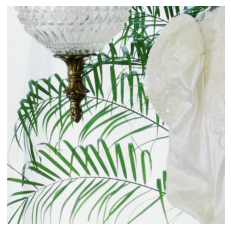

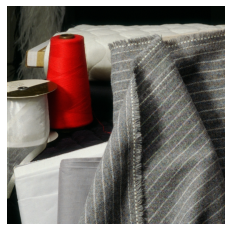

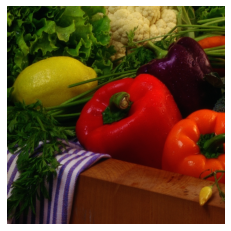

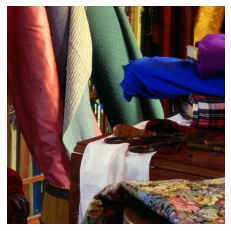

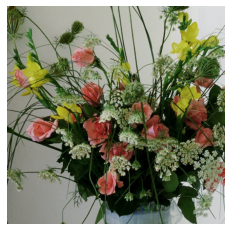

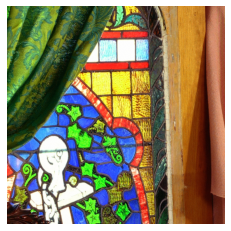

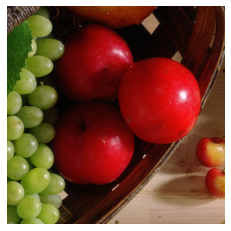

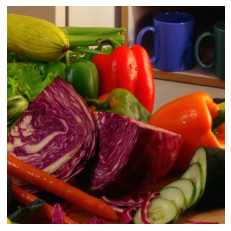

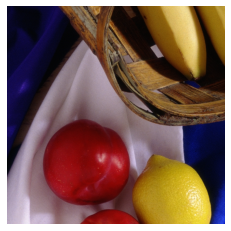

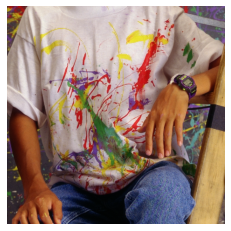

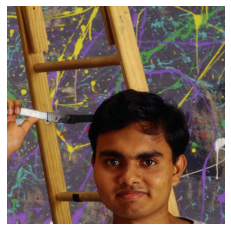

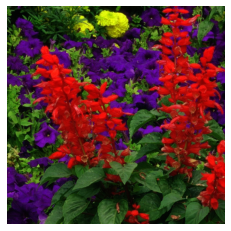

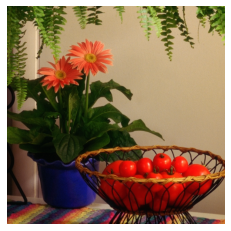

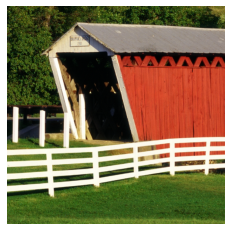

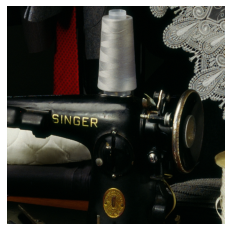

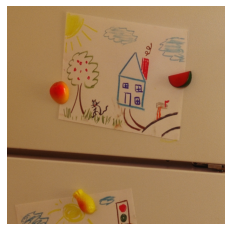

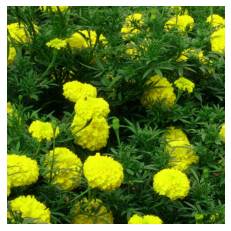

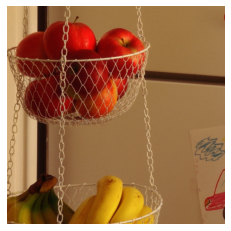

In [104]:
# process inputs

# path = "/Users/qiaowenyang/Desktop/22ss/jssxx/labs/Codingproject/code/inputs"
path = "/home/brighterw/PHOT22spr/coding_pj/Demosaicing/inputs"
truth = "/home/brighterw/PHOT22spr/coding_pj/Demosaicing/ground_truth"

psnr = {}

def process(path):
    for file in os.listdir(path):
        # the input file
        filename1 = os.path.join(path, file)
        img1 = imread(filename1).astype('float32')
        img_cfa = img1[:, :, 0] + img1[:, :, 1] + img1[:, :, 2]
        img_d = PCSD_Demosaicing(img_cfa)
        # the ground truth file
        filename2 = os.path.join(truth, file)
        img2 = imread(filename2).astype('float32')
        # calculate PSNR
        psnr[file] = PSNR(img_d, img2)
        # show the output image
        print(f"{file} after demosaicing:")
        plt.figure()
        plt.imshow(img_d / 255)
        plt.axis('off')
        plt.savefig(f"pcsd_outputs/demosaicing_{file}", dpi=200)

process(path)

In [105]:
# psnr result

import csv

f = open('psnr_pcsd.csv', 'w')

with f:
    fnames = ['filename', 'psnr']
    writer = csv.DictWriter(f, fieldnames=fnames)    
    writer.writeheader()
    for key, value in psnr.items():
        writer.writerow({'filename' : key, 'psnr': value})

print(psnr)

{'4.png': 33.96586226819386, '7.png': 35.14620103460512, '11.png': 36.83096275328426, '2.png': 33.59833431926757, '3.png': 31.520388891016914, '1.png': 27.06793192929708, '15.png': 37.246387705686786, '10.png': 36.5799906698645, '14.png': 37.37721519489922, '5.png': 31.97786700240988, '6.png': 34.63693825119357, '17.png': 30.010277656562664, '9.png': 34.39665883529851, '18.png': 32.87665198031866, '8.png': 36.26015267443555, '13.png': 39.016542555891576, '16.png': 30.18334185808172, '12.png': 36.70901822157464}
